In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os

warnings.filterwarnings('ignore')
%matplotlib inline

# Load Datasets

In [17]:
def load_dataset(dataset):
    """ "loads a given hdf file"""
    data_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\raw"
    dataset_path = os.path.join(data_path, f"{dataset}.hd5")
    df = pd.read_hdf(dataset_path)

    return df

backgrounds = ["ttsemileptonic", "fully_leptonic", "fully_hadronic"]
signal = "ttH"

original_df = load_dataset(signal)
original_df['event_type'] = signal
original_df['signal'] = 1

for background in backgrounds:
    dataset = load_dataset(background)
    dataset['event_type'] = background
    dataset['signal'] = 0
    original_df = original_df.append(dataset, ignore_index=True)


# Remove Useless Columns

In [18]:
completely_useless_cols = ['entry', 'hashed_filename', 'xs_weight', 'weight_nominal', 'dataset']
not_useless_cols = list(set(original_df.columns) - set(completely_useless_cols))

full_df = original_df[not_useless_cols]

# Plot Correlation Matrix

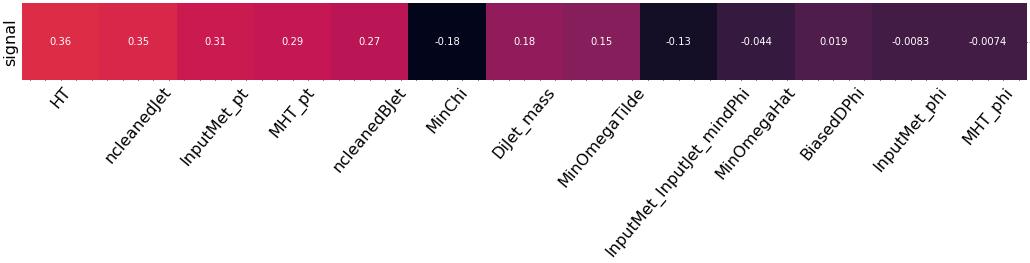

In [4]:
# shows how the signal correlates with other variables

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']) as style:
    corrmat = full_df.corr()
    corr = corrmat[['signal']].sort_values(by=['signal'], ascending=False, key=abs)
    f, ax = plt.subplots(figsize=(18, 12))
    sns.heatmap(corr[1:].T, vmax=.8, annot=True, square=True, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 50)
    plt.show()

In [5]:
# removes unnecessary columns
event_cols = ['BiasedDPhi',
               'HT', 
               'DiJet_mass',
               'MinChi',
               'InputMet_pt', 
               'InputMet_phi',
               'MHT_phi',
               'InputMet_InputJet_mindPhi',
               'MinOmegaHat',
               'MHT_pt',
               'MinOmegaTilde',
               'ncleanedJet',
               'ncleanedBJet', 
]


X, y = full_df.drop('signal', axis=1), full_df['signal']
event_X = X[event_cols]
print("Removed Columns: ", set(X.columns) - set(event_cols))

Removed Columns:  {'cleanedJet_neHEF', 'cleanedJet_btagDeepB', 'cleanedJet_pt', 'cleanedJet_phi', 'cleanedJet_mass', 'cleanedJet_area', 'cleanedJet_chHEF', 'event_type', 'cleanedJet_eta'}


In [6]:
# shows mutual information score for each feature
from sklearn.feature_selection import mutual_info_classif

discrete_features = (event_X.dtypes == int)

def make_mi_scores(event_X, y, discrete_features):
    mi_scores = mutual_info_classif(event_X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Score", index=event_X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(event_X, y, discrete_features)

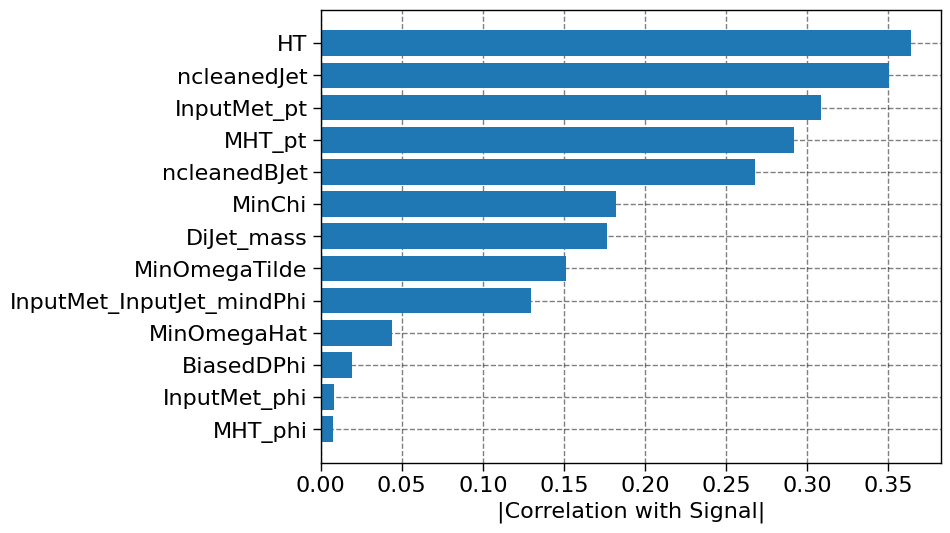

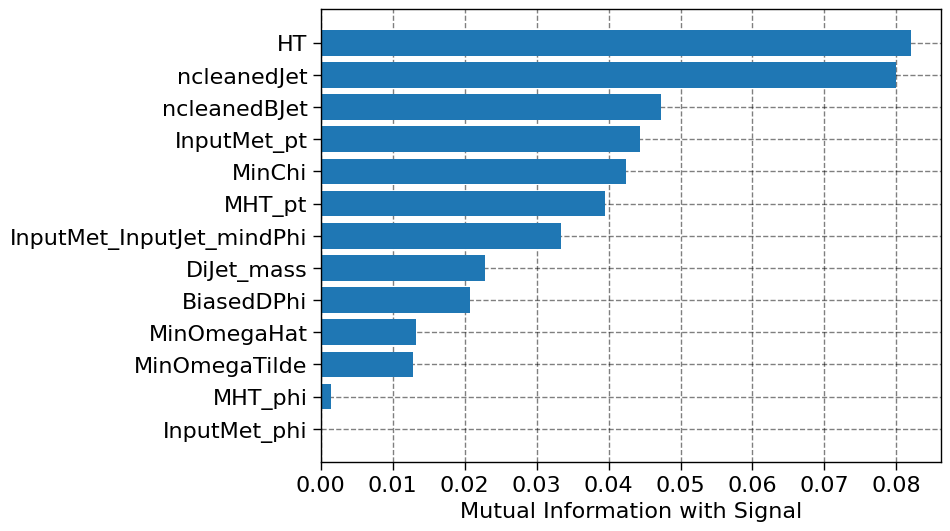

In [7]:
# plots the mutual information scores
def plot_scores(scores, xlabel):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    with plt.style.context(['nature', 'grid', 'notebook']):
        plt.figure(dpi=100, figsize=(8, 6))
        plt.barh(width, scores)
        plt.yticks(width, ticks)
        plt.xlabel(xlabel)

series_corr = corr.squeeze()
series_corr = series_corr.drop('signal')
series_corr = np.abs(series_corr)
series_corr = series_corr.sort_index()
mi_sorted = mi_scores.sort_index()

plot_scores(series_corr, "|Correlation with Signal|")
plot_scores(mi_sorted, "Mutual Information with Signal")

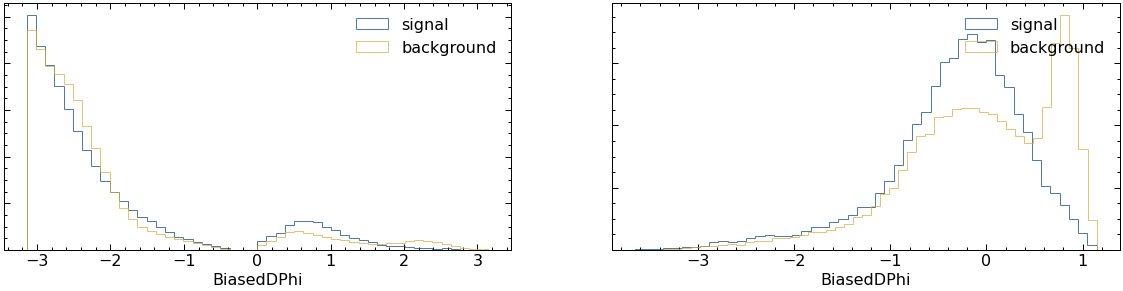

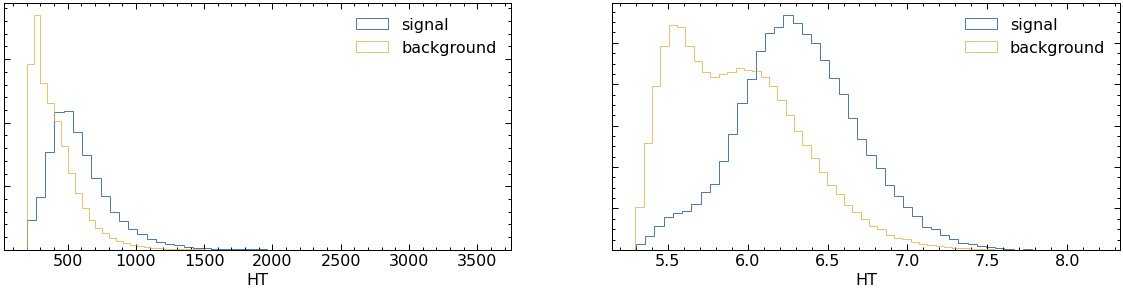

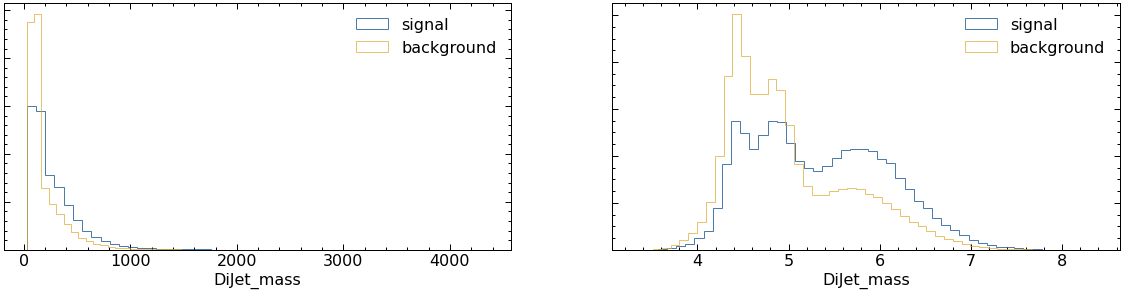

In [8]:
def skew_comparison(col_name, df):

    bins = 50

    signal = df[col_name].loc[df['signal'] == 1]
    bg = df[col_name].loc[df['signal'] == 0] 
    histtype = 'step'
    alpha = 1.0
    
    with plt.style.context(['science', 'notebook', 'high-contrast']) as style:
        
        plt.figure(figsize=(20,10))

        # skewed plot
        ax = plt.subplot(2,2,1)
        plt.xlabel(col_name)
        plt.hist(signal, bins, alpha=alpha, label='signal', density=True, histtype=histtype)
        plt.hist(bg, bins, alpha=alpha, label='background', density=True, histtype=histtype)

        ax.tick_params(labelleft=False)
        
        plt.legend()
        
        # unskewed plot
        unskewed_signal = np.log(signal)
        unskewed_bg = np.log(bg)
         
        ax = plt.subplot(2,2,2)
        plt.xlabel(col_name)
        plt.hist(unskewed_signal, bins, alpha=alpha, label='signal', density=True, histtype=histtype)
        plt.hist(unskewed_bg, bins, alpha=alpha, label='background', density=True, histtype=histtype)
        
        ax.tick_params(labelleft=False)

        plt.legend()
        plt.show()


skewed_cols = ['BiasedDPhi',
               'HT', 
               'DiJet_mass',
               'MinChi',
               'MHT_phi',
               'InputMet_pt', 
               'InputMet_InputJet_mindPhi',
               'MinOmegaHat',
               'MHT_pt',
               'MinOmegaTilde',
               'InputMet_phi',
               'InputMet_pt',
]

interesting_cols = ['BiasedDPhi', 'HT', 'DiJet_mass']

for col in interesting_cols:
    skew_comparison(col, full_df)

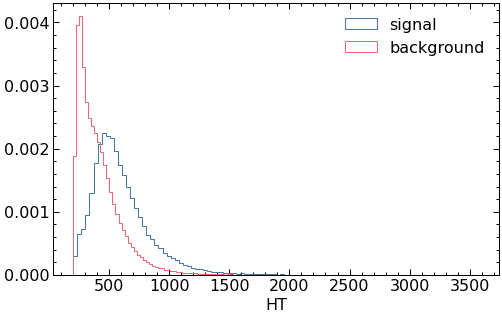

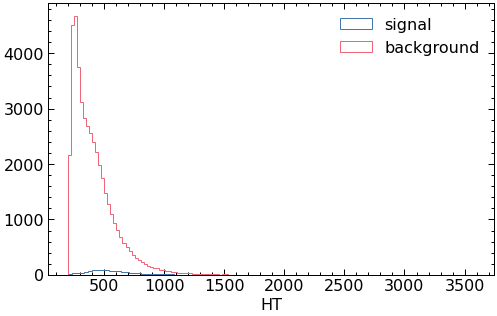

In [81]:
def hist_comparison(col_name, df):

    bins = 100
    lum = 140_000

    signal = df[col_name].loc[df['signal'] == 1]
    bg = df[col_name].loc[df['signal'] == 0] 
    histtype = 'step'
    alpha = 1.0

    with plt.style.context(['science', 'notebook', 'bright']) as style:

        # unnormalised plot
        plt.figure(figsize=(8,5))
        plt.xlabel(col_name)
        plt.hist(signal, bins, alpha=alpha, label='signal', density=True, histtype=histtype)
        plt.hist(bg, bins, alpha=alpha, label='background', density=True, histtype=histtype)

        plt.legend()
        plt.show()

        # normalised plot
        plt.figure(figsize=(8,5))
        signal_weights = df['xs_weight'].loc[df['signal'] == 1] * lum
        bg_weights = df['xs_weight'].loc[df['signal'] == 0] * lum

        plt.xlabel(col_name)
        plt.hist(signal, bins, alpha=alpha, label='signal', weights=signal_weights, log=False, histtype=histtype)
        plt.hist(bg, bins, alpha=alpha, label='background', weights=bg_weights, log=False, histtype=histtype)

        plt.legend()
        plt.show()


hist_comparison('HT', original_df)

# PCA

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# fully hadronic is the smallest class so can't sample more than this number per class
n_samples_per_class = len(full_df.loc[full_df['event_type'] == 'fully_hadronic'])

event_types = np.unique(full_df['event_type'])
data_sample = full_df.copy()[0:0]

for event_type in event_types:
    event_sample = full_df.loc[full_df['event_type'] == event_type].sample(n=n_samples_per_class, random_state=0)
    data_sample = data_sample.append(event_sample)
    
data_sample = shuffle(data_sample)

event_sample, labels = data_sample[event_cols], data_sample['event_type']
event_sample[event_cols] = StandardScaler().fit_transform(event_sample[event_cols])

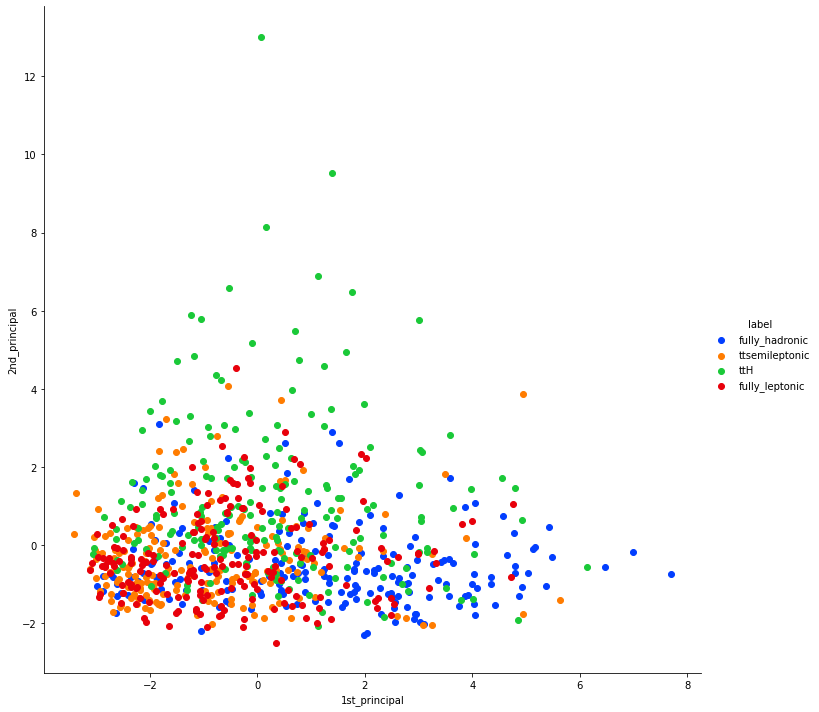

In [10]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.n_components = 2

pca_data = pca.fit_transform(event_sample)
pca_data = np.vstack((pca_data.T, labels)).T

pca_df = pd.DataFrame(pca_data, columns=("1st_principal", "2nd_principal", "label"))
sns.FacetGrid(pca_df, hue='label', size=10, palette='bright').map(plt.scatter, "1st_principal", "2nd_principal").add_legend()

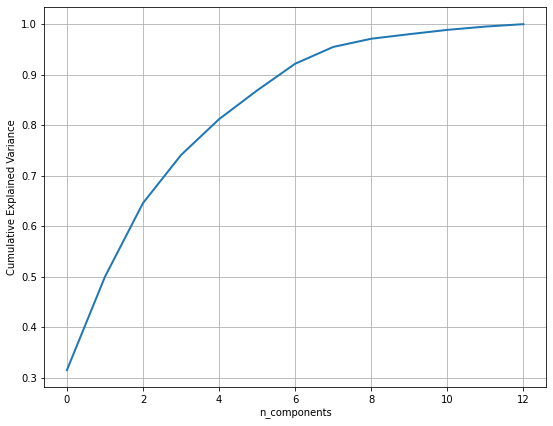

In [11]:
pca.n_components = len(event_cols)
pca_data = pca.fit_transform(event_sample)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(9, 7))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# TSNE

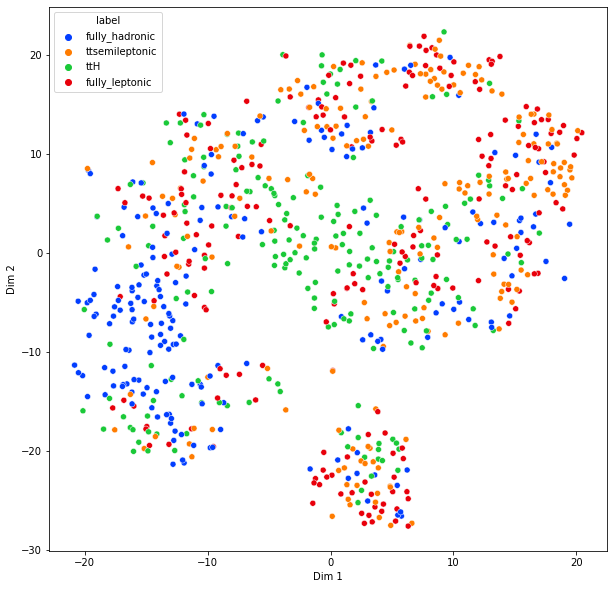

In [12]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate='auto')
tsne_data = model.fit_transform(event_sample)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim 1", "Dim 2", "label"))

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsne_df, x='Dim 1', y='Dim 2', hue='label', palette='bright')
plt.show()

In [13]:
import plotly.express as px

model_3d = TSNE(n_components=3, random_state=0, perplexity=50, learning_rate='auto')
tsne_data_3d = model_3d.fit_transform(event_sample)

tsne_data_3d = np.vstack((tsne_data_3d.T, labels)).T
tsne_df_3d = pd.DataFrame(tsne_data_3d, columns=("Dim 1", "Dim 2", "Dim 3", "label"))

fig = px.scatter_3d(tsne_df_3d, x='Dim 1', y='Dim 2', z='Dim 3', color='label', width=2000, height=2000)

fig.write_html("3d_plotly.html")